In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
ppp = pd.read_csv('../data/cleaned_1and2_reduced.csv')
ppp.head()

,SBAOfficeCode,ProcessingMethod,BorrowerZip,LoanStatus,Term,SBAGuarantyPercentage,InitialApprovalAmount,CurrentApprovalAmount,ServicingLenderLocationID,RuralUrbanIndicator,...,PAYROLL_PROCEED,MORTGAGE_INTEREST_PROCEED,RENT_PROCEED,REFINANCE_EIDL_PROCEED,HEALTH_CARE_PROCEED,DEBT_INTEREST_PROCEED,BusinessType,OriginatingLenderLocationID,Gender,Veteran
0,156,PPP,06853-1207,1,24,100,18457.00,18457.00,9551,U,...,18457.00,0.0,0.0,0.0,0.0,0.0,Limited Liability Company(LLC),9551,Unanswered,Unanswered
1,156,PPP,06107-2103,1,24,100,18457.00,18457.00,9551,U,...,18457.00,0.0,0.0,0.0,0.0,0.0,Corporation,9551,Female Owned,Unanswered
2,156,PPS,06278-1421,1,60,100,18456.65,18456.65,93682,R,...,18450.65,0.0,0.0,0.0,0.0,0.0,Limited Liability Company(LLC),93682,Female Owned,Non-Veteran
3,156,PPP,06357-1742,1,60,100,18456.00,18456.00,93490,U,...,18455.00,0.0,0.0,0.0,0.0,0.0,Single Member LLC,93490,Male Owned,Non-Veteran
4,156,PPP,06111-2212,1,60,100,18455.00,18455.00,433860,U,...,18455.00,0.0,0.0,0.0,0.0,0.0,Corporation,529111,Unanswered,Unanswered


What is our full parameter set?

In [4]:
categorical_features = ppp.dtypes[ppp.dtypes == 'object']
categorical_features

ProcessingMethod          object
BorrowerZip               object
RuralUrbanIndicator       object
HubzoneIndicator          object
LMIIndicator              object
BusinessAgeDescription    object
CD                        object
Race                      object
Ethnicity                 object
BusinessType              object
Gender                    object
Veteran                   object
dtype: object

In [5]:
# numeric columns
numeric_features = ppp.dtypes[ppp.dtypes != 'object']
numeric_features

SBAOfficeCode                    int64
LoanStatus                       int64
Term                             int64
SBAGuarantyPercentage            int64
InitialApprovalAmount          float64
CurrentApprovalAmount          float64
ServicingLenderLocationID        int64
JobsReported                     int64
NAICSCode                        int64
UTILITIES_PROCEED              float64
PAYROLL_PROCEED                float64
MORTGAGE_INTEREST_PROCEED      float64
RENT_PROCEED                   float64
REFINANCE_EIDL_PROCEED         float64
HEALTH_CARE_PROCEED            float64
DEBT_INTEREST_PROCEED          float64
OriginatingLenderLocationID      int64
dtype: object

In [6]:
# Include all  numeric features
subset_cols = numeric_features.index.to_list()
subset_cols

['SBAOfficeCode',
 'LoanStatus',
 'Term',
 'SBAGuarantyPercentage',
 'InitialApprovalAmount',
 'CurrentApprovalAmount',
 'ServicingLenderLocationID',
 'JobsReported',
 'NAICSCode',
 'UTILITIES_PROCEED',
 'PAYROLL_PROCEED',
 'MORTGAGE_INTEREST_PROCEED',
 'RENT_PROCEED',
 'REFINANCE_EIDL_PROCEED',
 'HEALTH_CARE_PROCEED',
 'DEBT_INTEREST_PROCEED',
 'OriginatingLenderLocationID']

In [7]:
# To speed up computation, work with reduced dimensionality
# Add back categorical features as we tune
subset_cols.append('BusinessType')

# subset_cols
subset_ppp = ppp[subset_cols]

In [8]:
subset_ppp.columns

Index(['SBAOfficeCode', 'LoanStatus', 'Term', 'SBAGuarantyPercentage',
       'InitialApprovalAmount', 'CurrentApprovalAmount',
       'ServicingLenderLocationID', 'JobsReported', 'NAICSCode',
       'UTILITIES_PROCEED', 'PAYROLL_PROCEED', 'MORTGAGE_INTEREST_PROCEED',
       'RENT_PROCEED', 'REFINANCE_EIDL_PROCEED', 'HEALTH_CARE_PROCEED',
       'DEBT_INTEREST_PROCEED', 'OriginatingLenderLocationID', 'BusinessType'],
      dtype='object')

In [9]:
# Define X and y
X = subset_ppp.drop(columns=['LoanStatus'])
y = subset_ppp['LoanStatus']

In [10]:
X.shape[1]

17

Deciding on a train-val-test split proportion
A rule of thumb is that the validation set fraction should be inversely proportional to the log2 of the number of free adjustable parameters.

In [11]:
print(f'{round((1 / np.sqrt(X.shape[1])*100), 2)}% should be reserved for validation')

24.25% should be reserved for validation


In [12]:
print(f'{round(((1 - 1 / np.sqrt(X.shape[1]))*100), 2)}% should be used for training')

75.75% should be used for training


In [13]:
baseline_accuracy = y.value_counts(normalize=True)[1]
y.value_counts(normalize=True)

LoanStatus
1    0.908
0    0.092
Name: proportion, dtype: float64

### Preprocessing 
#### OneHotEncoder to dummify the categorical features

In [14]:
# Make a list of categorical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

In [15]:
len(subset_ppp['BusinessType'].unique())

26

In [16]:
# Preprocessing pipeline for categorical features
preprocessor = ColumnTransformer(transformers=[
    ('oh', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)  
])

In [17]:
# Define the Random Forest model with preprocessing and classifier
# Use default tuning parameters
rf = RandomForestClassifier(n_estimators=5, max_depth=3, )

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', rf)
])

In [18]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('oh',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BusinessType']),
                                                 ('num', StandardScaler(),
                                                  ['SBAOfficeCode', 'Term',
                                                   'SBAGuarantyPercentage',
                                                   'InitialApprovalAmount',
                                                   'CurrentApprovalAmount',
                                                   'ServicingLenderLocationID',
                                                   'JobsReported', 'NAICSCode',
                                                   'UTILITIES_PROCEED',
                                                   'PAYROLL_PROCEED',
                                                   'MORTGAGE_INTEREST_PROCEED',
                                                   'RENT_PROCEED',
                                                   'REFINANCE_EIDL_PROCEED',
                                                   'HEALTH_CARE_PROCEED',
                                                   'DEBT_INTEREST_PROCEED',
                                                   'OriginatingLenderLocationID'])])),
                ('rf', RandomForestClassifier(max_depth=3, n_estimators=5))])

In [20]:
pipe.score(X_train, y_train)

0.9081028868404756

In [22]:
pipe.score(X_test, y_test)

0.9077436243877723

In [23]:
# Delete this! Just peeking at holdout data
# pipe.score(X_test, y_test) # 0.9108

We remark that after splitting data to create a holdout set, performance apparently reduced from score 0.92 to 0.91.  However, we are still working with a very small subset of the features.  We expect that after we add more columns back, and potentially concatenate more of the PPP loans from the rest of the 5GB datset, we will see restoration of Validation Set accuracy.  This is an important thing to do because we want to be able to have greater confidence in interpreting the efficacy of our model on holdout (unseen) data.

In [24]:
# Reassemble the feature names so that we can map these correctly to feature importances

transformed_feature_names = pipe.named_steps['preprocessor'].named_transformers_['oh']      .get_feature_names_out(categorical_cols).tolist()
all_feature_names = transformed_feature_names + numerical_cols
all_feature_names

['BusinessType_501(c) – Non Profit except 3,4,6,',
 'BusinessType_501(c)19 – Non Profit Veterans',
 'BusinessType_501(c)3 – Non Profit',
 'BusinessType_501(c)6 – Non Profit Membership',
 'BusinessType_Cooperative',
 'BusinessType_Corporation',
 'BusinessType_Employee Stock Ownership Plan(ESOP)',
 'BusinessType_Housing Co-op',
 'BusinessType_Independent Contractors',
 'BusinessType_Joint Venture',
 'BusinessType_Limited  Liability Company(LLC)',
 'BusinessType_Limited Liability Partnership',
 'BusinessType_Non-Profit Childcare Center',
 'BusinessType_Non-Profit Organization',
 'BusinessType_Partnership',
 'BusinessType_Professional Association',
 'BusinessType_Qualified Joint-Venture (spouses)',
 'BusinessType_Rollover as Business Start-Ups (ROB',
 'BusinessType_Self-Employed Individuals',
 'BusinessType_Single Member LLC',
 'BusinessType_Sole Proprietorship',
 'BusinessType_Subchapter S Corporation',
 'BusinessType_Tenant in Common',
 'BusinessType_Tribal Concerns',
 'BusinessType_Trus

In [144]:
# Get feature importances from the trained model
feature_importances = pipe.named_steps['rf'].feature_importances_
len(feature_importances)

42

In [145]:
# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
sorted_importances = importance_df.sort_values(by='Importance', ascending=False)
top_features = sorted_importances[sorted_importances['Importance'] > 0]
top_features

,Feature,Importance
27,Term,3.994239e-01
41,OriginatingLenderLocationID,1.761027e-01
29,InitialApprovalAmount,1.483764e-01
35,PAYROLL_PROCEED,1.205263e-01
30,CurrentApprovalAmount,6.175452e-02
10,BusinessType_Limited Liability Company(LLC),3.079272e-02
5,BusinessType_Corporation,3.079252e-02
18,BusinessType_Self-Employed Individuals,2.926638e-02
20,BusinessType_Sole Proprietorship,1.559355e-03
32,JobsReported,6.422636e-04


In [26]:
# Examine y predictions
y_pred = pipe.predict(X_test)
pd.Series(y_pred).value_counts(normalize=True)

1    0.999993
0    0.000007
Name: proportion, dtype: float64

In [27]:
# Examine the confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [28]:
print(cm)

[[     3  41515]
 [     0 408478]]


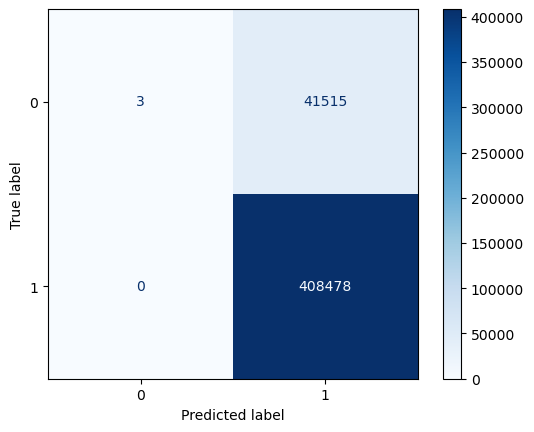

In [30]:
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap='Blues');

In [31]:
# Compute overall accuracy from confusion matrix
overall_accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()

In [32]:
# Calculate precision, recall, and F1-score for each class
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
# recall = cm.diagonal() / (cm.sum(axis=1) + 1)
# f1_score = 2 * (precision * recall) / (precision + recall)

In [33]:
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
# print(f"Recall (Sensitivity): {recall}")
# print(f"F1-Score: {f1_score}")

Overall Accuracy: 0.9077
Baseline Accuracy: 0.9080
Precision: 0.9077


# TO-DO >>>

## Data cleaning
~~collapse target into binary~~

## Holdout - best practices 
~~split train val test 80 10 10~~

### Improving performance
## The numerical columns
~~0) add all numeric features back in~~
1) feature engineer multicollinear PROCEEDS variables

## Feature engineering to handle categorical features
exclude categorical vals where there are too many unique values

how to narrow down cat cols:
1) engineer feature to reduce number of unique values by doing top 5, and 'other'
2) ordinal labeling
3) examine feature importance and drop least important, then retrain

### Downsample as needed until it finishes within reasonable time

## Scale back up to more data 
Google colab for scale up

# Optional
cross-validation -- why do we do this
~~no need to boostrap resample, sufficient to binarize~~
~~NN keras~~

## Other kinds of models to try
### Ensembling an ensemble could be interesting
0) RandomForest
1) XGBoost
2) knn
3) SVM
4) Multilayer perceptron NN - fewer hyperparameters